# `dIdV.ipynb`

Notebook for dIdV study fits

- didv notes:
- square wave
- 100 Hz
- 20 mV
- gain 50
- offx - QET bias in V
- Sig Gen

In [46]:
# imports
import sys
import os
import pickle
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.special as ss
import scipy.optimize as so
import scipy.integrate as si
import scipy.stats as st


# custom modules
from picoscopedata import PicoscopeData
from utilities import *


find_imports()
import qetpy as qp
import optimal_filter_utils as of


In [47]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [48]:
# base location of "B13_Runs" folder
folder_base_candidates = [
    'D:', # on the cryolab2 computer
    'C:/Users/MINER/Documents', # on Oxford computer
    '/Volumes/B13Cryolab_Share' # connecting to shared drives from Mac
]

folder_base = find_folder('B13 Cryolab', *folder_base_candidates)
print(folder_base)

C:/Users/MINER/Documents


In [49]:
# read in results from IbIs analysis
runnum = 4
runname = '20250516'

with open(f'C:/Users/MINER/Documents/B13 Cryolab/Run{runnum}/IbIs Data/{runname}_results.dat', 'rb') as f:
    ibis, ivfits, tr_fits = pickle.load(f)

In [50]:
import importlib
import picoscopedata
importlib.reload(picoscopedata)
from picoscopedata import PicoscopeData

# config dict
drive_path = folder_base + f'/B13 Cryolab/Run{runnum}/dIdV Data'
channels = 'ABCD'
glob_pattern = drive_path + '/' + runname + '*' + '/*.csv'
print(glob_pattern)

didv = PicoscopeData(runname, drive_path, idx = range(64*16), vertical_stack = True, glob_pattern = glob_pattern, row_avg = 16, throw_nans = True)

C:/Users/MINER/Documents/B13 Cryolab/Run4/dIdV Data/20250516*/*.csv
collecting 1024 files with glob
Created new PicoscopeData object with 100004 data points
Channels: ['A', 'B', 'C', 'D', 'H']


In [51]:
if 0:
    features = ["ds", "DSB", "DSstd", "bs", "dp1", "dp2", "slope_left", "slope_right"]

    all_ch_features = {ch: {f: [] for f in features} for ch in channels}

    x_left = [2500 + i * 10_000 for i in range(10)]
    x_right = [7500 + i * 10_000 for i in range(10)]
    for i in range(64*16):
        df = pd.read_csv(didv.trace_file(i), skiprows = (1,2), na_values = ["∞", "-∞"])
        for ch in channels:
            trace = df['Channel ' + ch].values
            sa = trace[2500]
            sb = trace[7500]
            s1, s2 = sorted((sa, sb))
            p2 = trace[:7500].max()
            p1 = trace[:7500].min()

            SA = trace[x_left]
            SB = trace[x_right]

            DSB = np.mean(np.abs(SB - SA))
            DSstd = np.std(SB - SA)

            slope_left = np.polyfit(x_left, SA, 1)[0]
            slope_right = np.polyfit(x_right, SB, 1)[0]

            all_ch_features[ch]["ds"].append(s2 - s1)
            all_ch_features[ch]["DSB"].append(DSB)
            all_ch_features[ch]["DSstd"].append(DSstd)
            all_ch_features[ch]["bs"].append((s1+s2)/2)
            all_ch_features[ch]["dp1"].append(s1 - p1)
            all_ch_features[ch]["dp2"].append(p2 - s2)
            all_ch_features[ch]["slope_left"].append(slope_left)
            all_ch_features[ch]["slope_right"].append(slope_right)
    for ch in channels:
        all_ch_features[ch] = pd.DataFrame(all_ch_features[ch])

In [52]:
all_ch_features_cut = {ch: pd.DataFrame() for ch in channels}

all_ch_features_cut['A'] = all_ch_features['A'].loc[(all_ch_features['A']['ds'] > 0.55) * (abs(all_ch_features['A']['slope_right']) < 2.5e-6)]

all_ch_features_cut['B'] = all_ch_features['B'].loc[(all_ch_features['B']['ds'] < 3) * (abs(all_ch_features['B']['bs']) < 0.1) * (abs(all_ch_features['B']['slope_right']) < 2e-6)]

all_ch_features_cut['C'] = all_ch_features['C'].loc[(all_ch_features['C']['ds'] > 0.25) * (abs(all_ch_features['C']['slope_right']) < 2.5e-6)]

all_ch_features_cut['D'] = all_ch_features['D'].loc[(all_ch_features['D']['ds'] > 2.5) * (abs(all_ch_features['D']['slope_right']) < 5e-6)]

for ch in channels:
    print(f"Ch {ch}: {len(all_ch_features_cut[ch]) / 16}")

NameError: name 'all_ch_features' is not defined

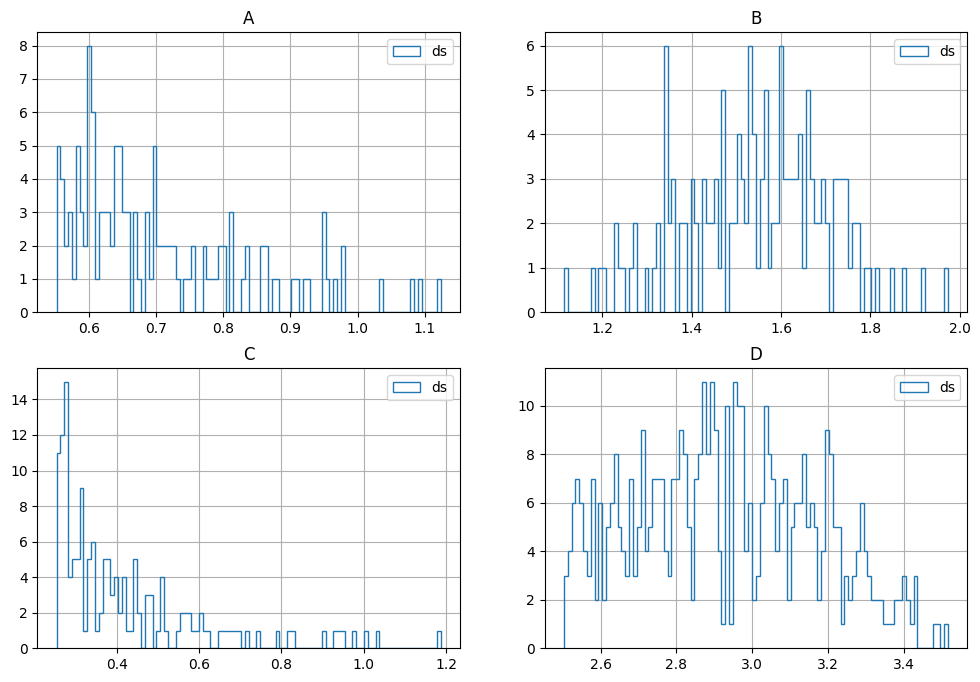

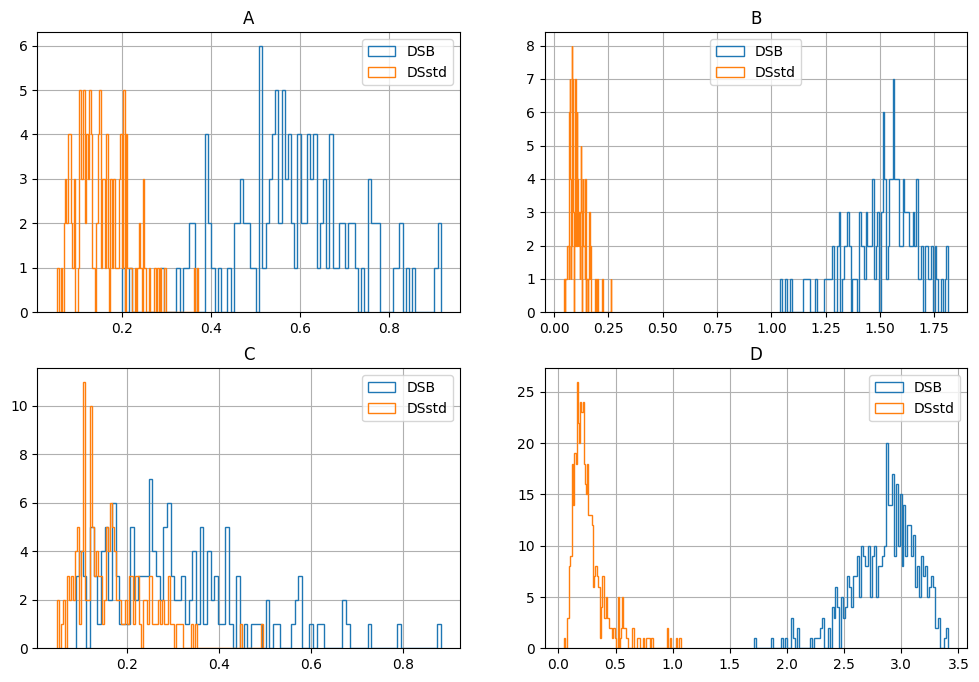

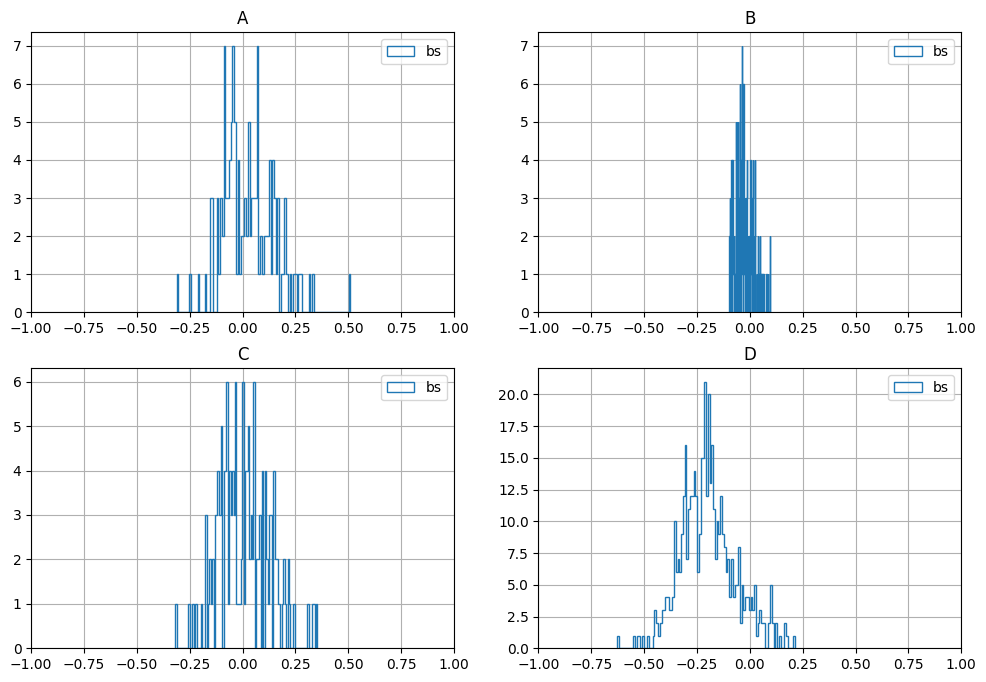

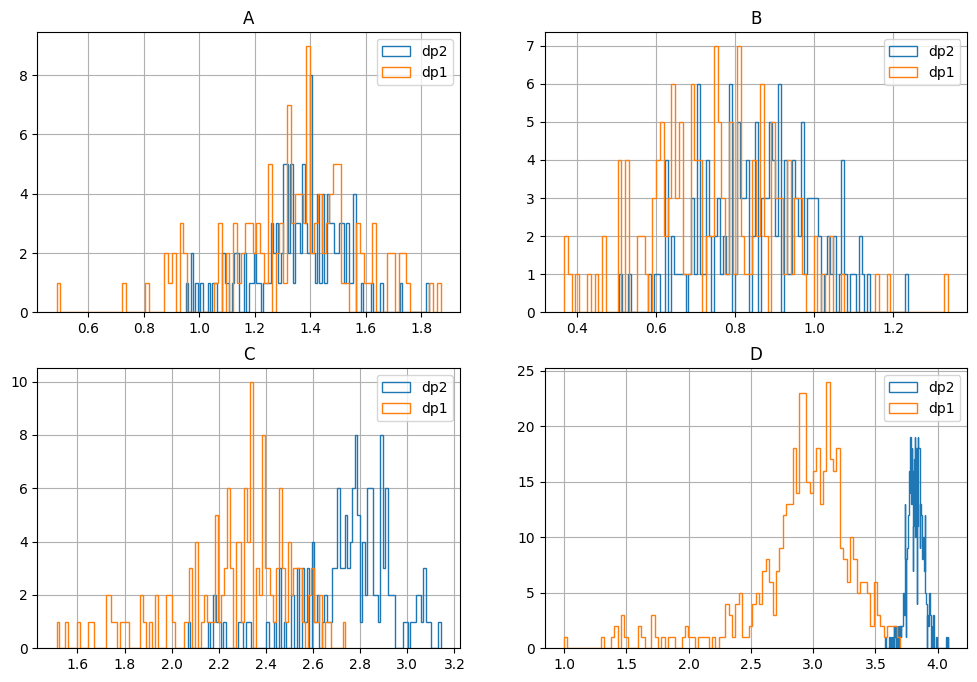

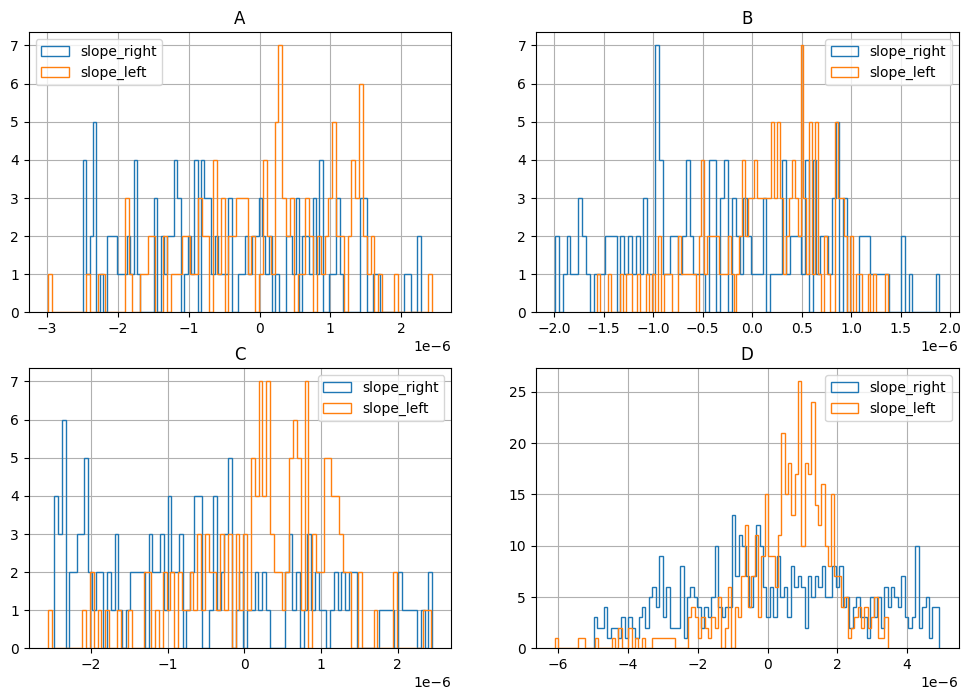

In [ ]:
after_cuts = True
if after_cuts:
    df = all_ch_features_cut
else:
    df = all_ch_features

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12,8))
for c, ax in zip('ABCD', axs.flatten()):
    ax.hist(np.array(df[c]['ds']), bins = 100, histtype = 'step', label = 'ds')
    ax.set_title(c)
    ax.grid()
    ax.legend()

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12,8))
for c, ax in zip('ABCD', axs.flatten()):
    ax.hist(np.array(df[c]['DSB']), bins = 100, histtype = 'step', label = 'DSB')
    ax.hist(np.array(df[c]['DSstd']), bins = 100, histtype = 'step', label = 'DSstd')
    ax.set_title(c)
    ax.grid()
    ax.legend()

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12,8))
for c, ax in zip('ABCD', axs.flatten()):
    ax.hist(np.array(df[c]['bs']), bins = 100, histtype = 'step', label = 'bs')
    ax.set_title(c)
    ax.set_xlim(-1,1)
    ax.grid()
    ax.legend()

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12,8))
for c, ax in zip('ABCD', axs.flatten()):
    ax.hist(np.array(df[c]['dp2']), bins = 100, histtype = 'step', label = 'dp2')
    ax.hist(np.array(df[c]['dp1']), bins = 100, histtype = 'step', label = 'dp1')
    ax.set_title(c)
    ax.grid()
    ax.legend()

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12,8))
for c, ax in zip('ABCD', axs.flatten()):
    ax.hist(np.array(df[c]['slope_right']), bins = 100, histtype = 'step', label = 'slope_right')
    ax.hist(np.array(df[c]['slope_left']), bins = 100, histtype = 'step', label = 'slope_left')
    ax.set_title(c)
    # ax.set_xlim(-,1)
    ax.grid()
    ax.legend()

In [53]:
for c in didv.channels:
    print(c, didv(c).shape)

A (8, 100004)
B (9, 100004)
C (9, 100004)
D (29, 100004)
H (100004,)


In [54]:
# convert didv.arrs to ADC (Amps):
for chan in channels:
    didv.arrs[chan] = didv.arrs[chan][:,:100000]
didv.resize(0,100_000)

In [55]:
c = 'B'
x = didv.arrs[c]
I,J = x.shape
for i in range(I):
    if any(np.isnan(x[i])):
        print(i)

In [56]:
didv('A').shape

(8, 100000)

In [57]:
R_ops = tr_fits.loc['R_op'].values
R_ops*1e3 # milliohms

array([55.99904731, 53.43758584, 53.37195107, 47.30330867])

In [58]:
B_avg = didv('B').mean(axis=0)
any(np.isnan(B_avg))

False

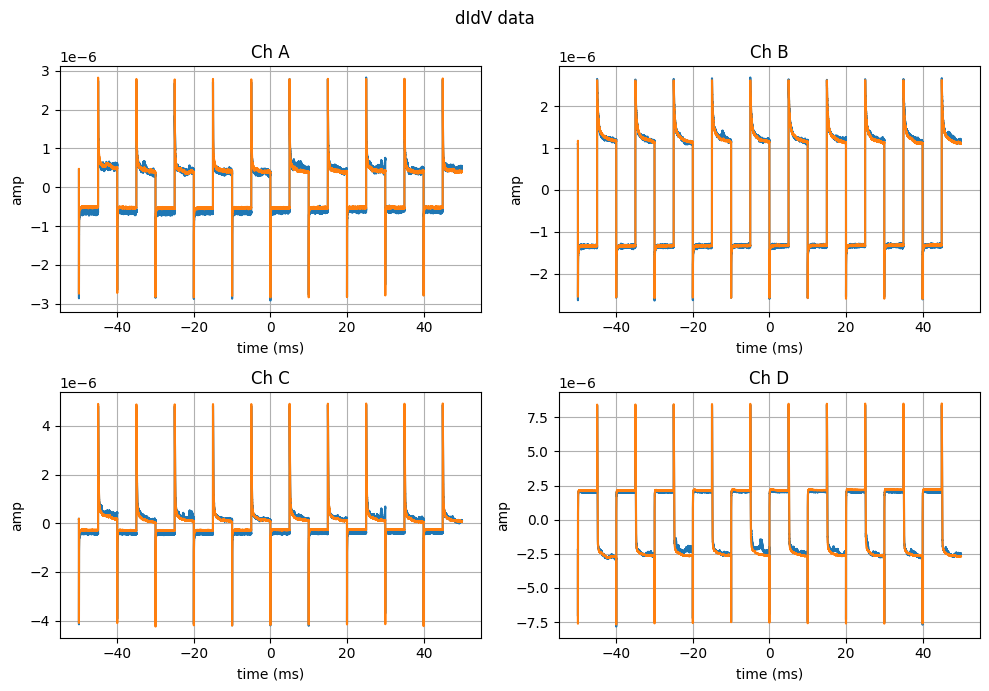

In [59]:
# plot DIDV data
numrows = (1+len(channels))//2

didv_waveform = didv('H')

fig, axs = plt.subplots(nrows = numrows, ncols = 2, figsize = (10,3.5*numrows))

fig.suptitle('dIdV data')


for i, (c, ax) in enumerate(zip(channels, axs.flatten())):

    ax.grid()
    ax.set_ylabel('amp')
    ax.set_xlabel('time (ms)')
    ax.set_title(f'Ch {c}')

    ax.plot(didv.ts*1e3, didv(c)[5])
    #ax.plot(didv.ts*1e3, didv('H')/10, alpha = 0.2)
    # for i in range(10):
    #     ax.axvline(didv.ts[2500 + i*10_000]*1e3)
    #     ax.axvline(didv.ts[7500 + i*10_000]*1e3)
    ax.plot(didv.ts*1e3, didv(c).mean(axis=0))
    #ax.set_ylim(-1e-6, 1e-6)
    #ax.plot(didv1.ts*1e3, didv1(c))

fig.tight_layout()


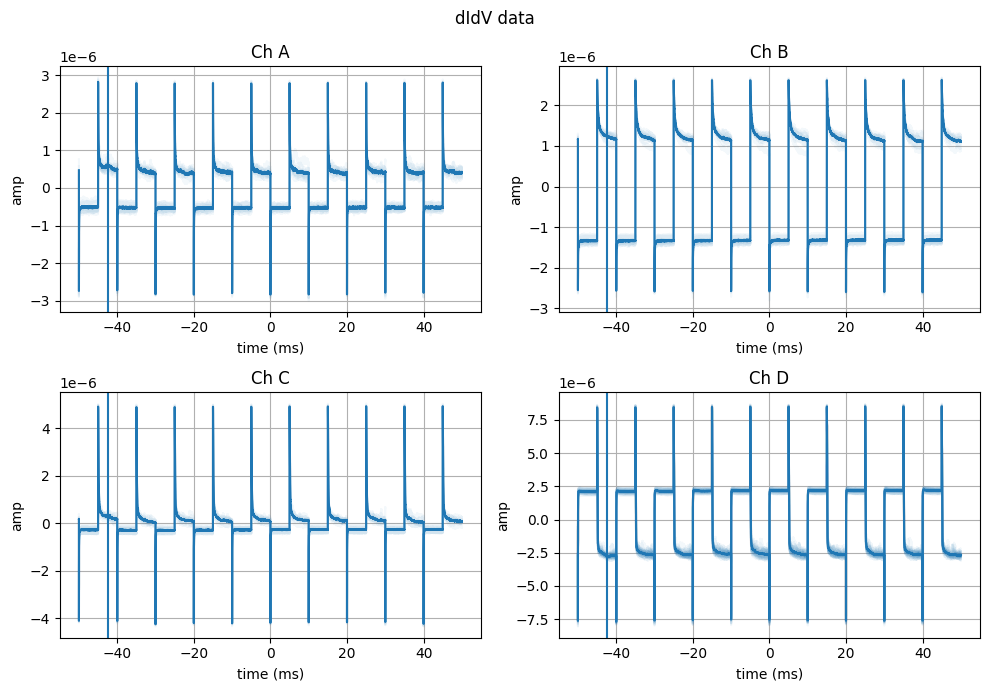

In [ ]:
# plot DIDV data
numrows = (1+len(channels))//2


fig, axs = plt.subplots(nrows = numrows, ncols = 2, figsize = (10,3.5*numrows))

fig.suptitle('dIdV data')


for i, (c, ax) in enumerate(zip(channels, axs.flatten())):

    ax.grid()
    ax.set_ylabel('amp')
    ax.set_xlabel('time (ms)')
    ax.set_title(f'Ch {c}')

    for t in didv(c):
        ax.plot(didv.ts*1e3, t, alpha = 0.05, color = 'C0')
    #ax.plot(didv.ts*1e3, didv('H')/10, alpha = 0.2)
    ax.axvline(didv.ts[7500]*1e3)
    ax.plot(didv.ts*1e3, didv(c).mean(axis=0))
    ax.set_ylim(-2e-6*(2 if c == 'D' else 1), 2e-6*(2 if c == 'D' else 1))
    #ax.plot(didv1.ts*1e3, didv1(c))

fig.tight_layout()


In [61]:
ff = np.round(1/((np.diff(didv.ts)).mean()))
freq = 100

ff, freq, ff/freq, didv.ts.size/10

(np.float64(1000000.0), 100, np.float64(10000.0), 10000.0)

In [62]:
didv.config

{'amp': 0.02,
 'freq': 100.0,
 'rsh': 0.02,
 'gain': 50.0,
 'offA': -275.4,
 'offB': -197.3,
 'offC': -143.4,
 'offD': -96.9}

In [63]:
didvfit = {}

In [64]:
channels

'ABCD'

In [65]:
ivfits.rp

array([[ 0.07822705,  0.06310076,  0.00297781, -0.00510192]])

In [66]:
didv.ts[0]

np.float64(-0.05000073871)

In [84]:
channels_quick = 'D'
#best_dt0 = {'A': 1.4e-6, 'B': 1.5e-6, 'C': 1.5e-6, 'D': -1.4e-6} # doubled
best_dt0 = {'A': 1.4e-6, 'B': 1.5e-6, 'C': 1.5e-6, 'D': 5.4e-6}

for c in channels_quick:
    i = channels.find(c)
    avg = didv(c).mean(axis=0)
    didvfit[c] = qp.DIDV(
        rawtraces = didv(c), #rawtraces = np.array([avg*1.001, avg*0.999]),
        fs = np.round(1/((np.diff(didv.ts)).mean())),
        sgfreq = didv.config['freq'],
        sgamp = func_to_ibias(didv.config['amp']),
        rsh = didv.config['rsh'],
        rp = abs(ivfits.rp[0,i]),
        dutycycle = 0.5,
        add180phase = False,
        autoresample = False,
        r0 = R_ops[i], # estimated TES resistance (Ohms)
        tracegain = 1,#(didv.config['gain'])*(10)*(1.2e3), # what to divide by to convert rawtraces to Amps (from convert_ADC)
        dt0 = best_dt0[c] # guess
        )

    didvfit[c].processtraces()

In [85]:
# fit 
for c in channels_quick:
    print('channel '+ c)
    didvfit[c].dofit(2) # Two poles fit
    didvfit[c].dofit(3) # Tree poles fit

channel D


In [86]:
for c in channels_quick:
    for p in (2,3):
        print(c, ',', p, 'pole:', didvfit[c].fitresult()[p]['params']['dt'])

D , 2 pole: 1.4175796716028524e-06
D , 3 pole: 1.4261337332817387e-06


In [87]:
didvfit

{'A': <qetpy.core.didv._didv.DIDV at 0x1dfa5231d10>,
 'B': <qetpy.core.didv._didv.DIDV at 0x1dfa534b390>,
 'C': <qetpy.core.didv._didv.DIDV at 0x1dfa6eca950>,
 'D': <qetpy.core.didv._didv.DIDV at 0x1df9cb3da90>}

channel D


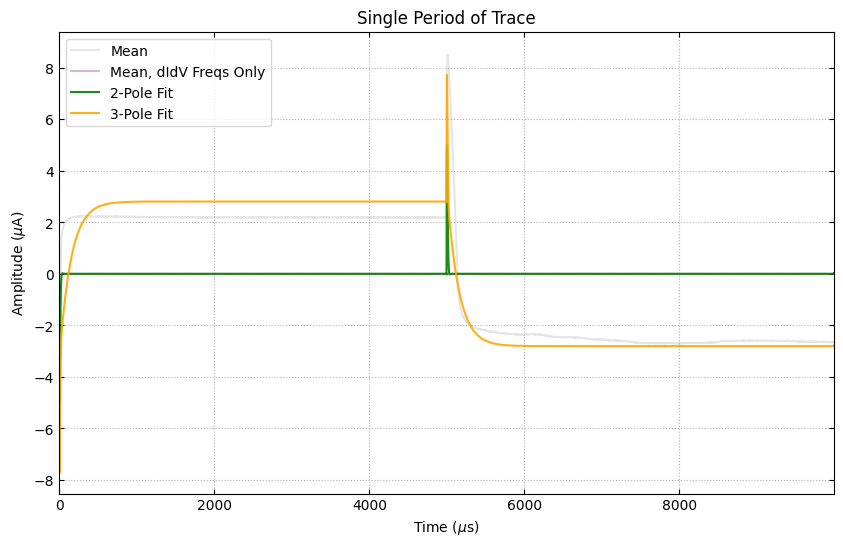

In [88]:
# display
for c in channels_quick:
    print('channel '+ c)
    didvfit[c].plot_single_period_of_trace(didv_freq_filt=True)
    #didvfit[c].plot_re_im_didv()

In [89]:
# "required params" ['rp', 'i0', 'i0_err','r0', 'r0_err']

In [90]:
ivfits.rp[0]
#didv.config['offA']

array([ 0.07822705,  0.06310076,  0.00297781, -0.00510192])

In [91]:
# dict used to calculate small signal params
for i, c in enumerate(channels):
    """
    ivsweep_results_fromdemo = {
        'close_loop_norm': 10*1.2e3*2, # idk (see above)
        'group_name_sweep': 'iv_didv_I2_D20230923_T131239',
        'i0': didv.config['off'+c]/1e6, # ?? from Irwin chapter the "steady state" current given as I0 (A) (maybe ites?)
        # maybe baseline current outside of square wave amplitude?
        'i0_err': 0.,#8.342312444985714e-12,
        'i0_off': 0.,#3.89669341000469e-09, # ioff from DIDV? - the current offset (A)
        'i0_off_err': 0.,#5.507092047349402e-12,
        'i0_variable_offset': 0., #-9.865689873695374e-06, # ??
        'ibias': didv.config['off'+c]/1e6, # applied QET bias current (A) (ibias)
        'ibias_off': 0.,#-3.381406772500224e-08, # current offset of the QET bias (A)
        'ibias_off_err': 0.,#1.0347074588426951e-11,
        'lgc_invert_offset': True, 
        'output_variable_gain': 50.0, # see above
        'output_variable_offset': 0,#-0.12332112342119217, # see above
        'p0': 3.2911e-15, # power of TES (W)? (from bulk_tes_noise.ipynb)
        'p0_err': 5e-17,
        'r0': R_ops[i], # TES resistance (Ohms)?
        'r0_err': ivfits.rnorm_err[0,i], #0.003534606260879604,
        'rn': ivfits.rnorm[0,i], # normal-state resistance (Ohms) ?
        'rn_err': ivfits.rnorm_err[0,i], 
        'rp': ivfits.rp[0,i], # parasitic resistance in non-shunt side of TES circuit (see above) (Ohms)
        'rp_err': ivfits.rp_err[0,i],
        'rshunt': ibis.config['rsh'], # shunt resistance (Ohms)
        'rshunt_err': ibis.config['rsh']/100
        }"""

    ivsweep_results = {
        'rp': didvfit[c]._rp, #max((ivfits.rp[0,i], 0)), 
        'i0': didv.config['off'+c]/1e6, 
        'i0_err': didv.config['off'+c]/1e8,
        'r0': R_ops[i], 
        'r0_err': R_ops[i]/100
    }


    didvfit[c].calc_smallsignal_params(ivsweep_results)

INFO: Calculating small signal parameters for 2-poles model 
INFO: Calculating small signal parameters for 3-poles model 
INFO: Calculating small signal parameters for 2-poles model 
INFO: Calculating small signal parameters for 3-poles model 
INFO: Calculating small signal parameters for 2-poles model 
INFO: Calculating small signal parameters for 3-poles model 
INFO: Calculating small signal parameters for 2-poles model 
INFO: Calculating small signal parameters for 3-poles model 


In [92]:
didvfit['A'].fitresult(3).keys()

dict_keys(['lgcfix', 'params_array', 'params', 'cov', 'errors', 'falltimes', 'cost', 'offset', 'offset_err', 'biasparams', 'smallsignalparams', 'ssp_light', 'didv0', 'dpdi0', 'dpdi0_err'])

In [93]:
for c in channels:
        # printing out results
        results = didvfit[c].fitresult()
        data = {'Model':['2-pole', '3-pole'],
                'Tau1 [usec]': ['{:.3g}'.format(1e6*np.abs(results[2]['params']['tau1'])),
                                '{:.3g}'.format(1e6*np.abs(results[3]['params']['tau1']))],
                'Tau2 [usec]': ['{:.3g}'.format(1e6*results[2]['params']['tau2']),
                                '{:.3g}'.format(1e6*results[3]['params']['tau2'])],
                'Tau3 [usec]': ['{:.3g}'.format(1e6*results[2]['params']['tau3']),
                                '{:.3g}'.format(1e6*results[3]['params']['tau3'])]}
                
                
        
        # Create a DataFrame
        df = pd.DataFrame(data)

        # Display the DataFrame
        print('Fit time constants, NOT dIdV Poles: ')
        print(df.to_string(index = False))
                
        data = {'Model':['2-pole', '3-pole'],
                'Tau+[usec]': ['{:.3g}'.format(1e6*results[2]['falltimes'][0]),
                        '{:.3g}'.format(1e6*results[3]['falltimes'][0])],
                'Tau-[usec]': ['{:.3g}'.format(1e6*results[2]['falltimes'][1]),
                        '{:.3g}'.format(1e6*results[3]['falltimes'][1])],
                'Tau3[usec]': ['{:.3g}'.format(1e6*results[2]['falltimes'][2]),
                        '{:.3g}'.format(1e6*results[3]['falltimes'][2])]}
        # Create a DataFrame
        df = pd.DataFrame(data)

        # Display the DataFrame
        print('\nTrue dIdV Poles: ')
        print(df.to_string(index = False))

        print('\n============\n')

Fit time constants, NOT dIdV Poles: 
 Model Tau1 [usec] Tau2 [usec] Tau3 [usec]
2-pole        55.3        2.57           0
3-pole        1.06    6.34e+03        27.5

True dIdV Poles: 
 Model Tau+[usec] Tau-[usec] Tau3[usec]
2-pole       2.85       17.6          0
3-pole       1.68        1.7       25.3


Fit time constants, NOT dIdV Poles: 
 Model Tau1 [usec] Tau2 [usec] Tau3 [usec]
2-pole        1.17    8.86e+03           0
3-pole        1.09     6.7e+03        50.9

True dIdV Poles: 
 Model Tau+[usec] Tau-[usec] Tau3[usec]
2-pole       1.35       1.35          0
3-pole       1.38       1.38       50.3


Fit time constants, NOT dIdV Poles: 
 Model Tau1 [usec] Tau2 [usec] Tau3 [usec]
2-pole        5.49        5.03           0
3-pole        1.87     1.3e+04        52.4

True dIdV Poles: 
 Model Tau+[usec] Tau-[usec] Tau3[usec]
2-pole       2.45       2.45          0
3-pole       1.77       1.78       49.4


Fit time constants, NOT dIdV Poles: 
 Model Tau1 [usec] Tau2 [usec] Tau3 [usec]

In [94]:
R_ops

array([0.05599905, 0.05343759, 0.05337195, 0.04730331])

In [95]:
didvfit['C'].fitresult(3)['smallsignalparams']

{'rsh': 0.02,
 'rp': np.float64(0.002977813302007984),
 'r0': np.float64(0.05337195106962166),
 'beta': np.float64(-1.4297703839310572),
 'l': np.float64(0.8372747749001316),
 'L': np.float64(5.204574577395237e-07),
 'tau0': np.float64(3.048794761909178e-07),
 'gratio': np.float64(0.13474427363249122),
 'tau3': np.float64(5.236562826439083e-05),
 'dt': np.float64(1.451346918055778e-06)}

In [96]:
signalparams = pd.DataFrame.from_dict({param: [didvfit[c].fitresult(3)['smallsignalparams'][param] for c in channels] for param in ['rsh', 'rp', 'r0', 'beta', 'l', 'L', 'tau0', 'gratio', 'tau3', 'dt']})
signalparams.index = list(channels)
signalparams.T

,A,B,C,D
rsh,2.000000e-02,2.000000e-02,2.000000e-02,2.000000e-02
rp,7.822705e-02,6.310076e-02,2.977813e-03,5.101920e-03
r0,5.599905e-02,5.343759e-02,5.337195e-02,4.730331e-02
beta,-2.752347e+00,-2.553735e+00,-1.429770e+00,4.532047e-01
l,1.269585e+00,1.196347e+00,8.372748e-01,1.000135e+00
L,6.166886e-07,4.882071e-07,5.204575e-07,3.125160e-07
tau0,-2.852327e-07,-2.137070e-07,3.048795e-07,1.161361e-05
gratio,-1.693311e-01,-4.580728e-02,1.347443e-01,5.457171e-01
tau3,2.747891e-05,5.093331e-05,5.236563e-05,7.990422e-05
dt,1.398824e-06,1.531775e-06,1.451347e-06,1.426134e-06


In [97]:
# calculate and plot dPdIs
if 0:
    for chan in channels:
        qp.get_dPdI_with_uncertainties(len(didv.ts)*didv.ts/4/(didv.ts[-1]-didv.ts[0])**2, didvfit[chan].fitresult()[3], lgcplot=True)

In [101]:
# save results
if 1:
    savefile = f'C:/Users/MINER/Documents/B13 Cryolab/Run{runnum}/dIdV Data/{runname}_results.dat'
    with open(savefile, 'wb') as f:
        pickle.dump(file = f, obj = {c: didvfit[c].fitresult() for c in channels})
    print('saved data to', savefile)

saved data to C:/Users/MINER/Documents/B13 Cryolab/Run4/dIdV Data/20250516_results.dat


In [102]:
didv.config

{'amp': 0.02,
 'freq': 100.0,
 'rsh': 0.02,
 'gain': 50.0,
 'offA': -275.4,
 'offB': -197.3,
 'offC': -143.4,
 'offD': -96.9}

Text(0, 0.5, 'amplitude (uA)')

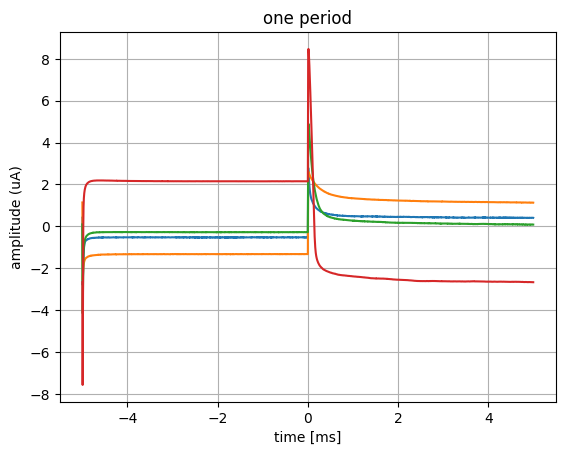

In [202]:
# trying to get impedance data directly

#Vb = pico_to_ibias(didv('H')[0,:10_000])*didv.config['rsh']*didv.conv['H'] 
Ib = pico_to_ibias(didv('H')[:10_000]) # amps through bias line
ts = didv.ts[:10_000] + 45e-3 # s

plt.figure()

traces = {}
Vb = didv.config['rsh']*Ib

for c in channels:

    avg = didv(c).mean(axis=0) 

    traces[c] = avg.reshape((10, 10_000)).mean(axis = 0) # amps
    #traces[c] = avg[:10_000]

    plt.plot(ts*1e3, traces[c]*1e6)

#plt.plot(ts*1e3, Ib*1e6)

plt.grid()
plt.title('one period')
plt.xlabel('time [ms]')
plt.ylabel('amplitude (uA)')

In [203]:
max(didv('H'))

np.float64(0.032639539999999995)

Text(0, 0.5, 'amplitude')

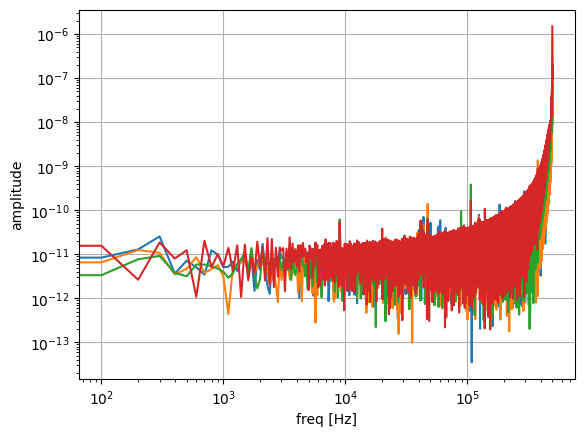

In [204]:
# frequency space

N = len(ts)
T = (ts[-1] - ts[0])/2

idx, tk, wn = of.get_idx_tk_wn(N, T)

fn = wn/2/np.pi

plt.figure()
plt.loglog()


Vn = of.fft(Vb)

Zn = {}

for c in channels:


    In = of.fft(traces[c])

    plt.plot(fn[N//2:], abs(In[N//2:]))

    Zn[c] = abs(Vn/In)

#plt.plot(fn[N//2:], abs(Vn[N//2:]))

plt.grid()
plt.xlabel('freq [Hz]')
plt.ylabel('amplitude')


In [205]:
didv.conv

{'': 0.0, 'A': 1.0, 'B': 1.0, 'C': 1.0, 'D': 1.0, 'H': 0.001}

In [206]:
didvfit['A'].fitresult(3)['params'].keys()

dict_keys(['A', 'B', 'C', 'tau1', 'tau2', 'tau3', 'dt'])

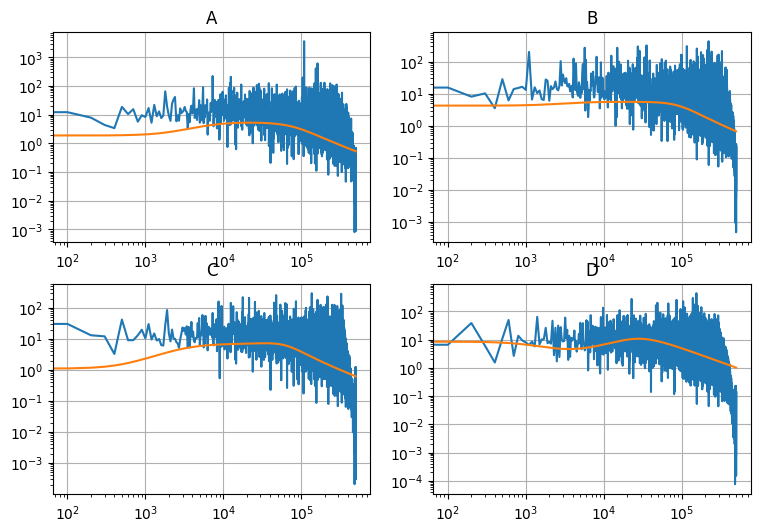

In [207]:
# impedance plot

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (9,6))
for ax in axs.flatten():
    ax.loglog()
    ax.grid()

for c, ax in zip(channels, axs.flatten()):

    ax.plot(fn, Zn[c])

    fit_params_dict = didvfit[c].fitresult(3)['params']

    A = fit_params_dict['A']
    B = fit_params_dict['B']
    C = fit_params_dict['C']
    tau1 = fit_params_dict['tau1']
    tau2 = fit_params_dict['tau2']
    tau3 = fit_params_dict['tau3']
    dt = fit_params_dict['dt'] 

    Zref = 1/abs(A*(1+1j*wn*tau2) + B/(1 + 1j*wn*tau1 - C/(1 + 1j*wn*tau3)))

    ax.plot(fn, Zref)
    ax.set_title(c)


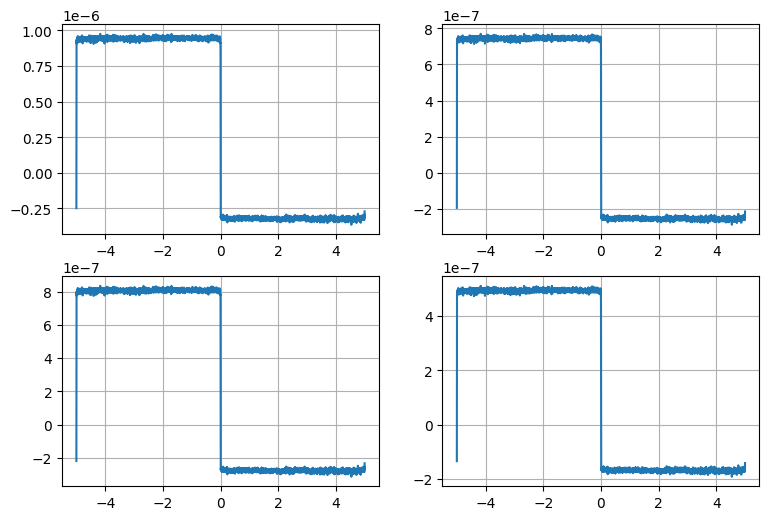

In [208]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (9,6))
for ax in axs.flatten():
    #ax.loglog()
    ax.grid()

for c, ax in zip(channels, axs.flatten()):

    #ax.plot(ts*1e3, traces[c])

    fit_params_dict = didvfit[c].fitresult(3)['params']

    A = fit_params_dict['A']
    B = fit_params_dict['B']
    C = fit_params_dict['C']
    tau1 = fit_params_dict['tau1']
    tau2 = fit_params_dict['tau2']
    tau3 = fit_params_dict['tau3']
    dt = fit_params_dict['dt'] 

    Zref = 1/abs(A*(1+1j*wn*tau2) + B/(1 + 1j*wn*tau1 - C/(1 + 1j*wn*tau3)))

    I0n = Vn/Zref

    I0 = of.ifft(I0n)

    ax.plot(ts*1e3, np.real(I0))

    

In [209]:
didvfit['A'].fitresult(3)['smallsignalparams'].keys()

dict_keys(['rsh', 'rp', 'r0', 'beta', 'l', 'L', 'tau0', 'gratio', 'tau3', 'dt'])

In [210]:
for c in channels:
    print(c, traces[c].mean()*1e6, tr_fits[c]['I0'])

A -0.023599380853135458 -310.45024042986904
B -0.024652584030071794 -219.13973091973807
C 0.002863332435173608 -143.35321238918888
D -0.08580896903660537 -96.94955715024523


A 0.05599904730789151 0.05599904730789151
B 0.05343758584082337 0.05343758584082337
C 0.05337195106962166 0.05337195106962166
D 0.047303308674271606 0.047303308674271606


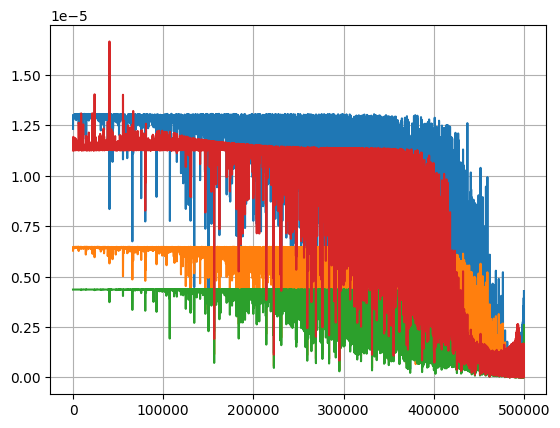

In [211]:
plt.figure()
plt.grid()

dpdi_num = {}

for c in channels:
    param_dict = didvfit[c].fitresult(3)['smallsignalparams']

    rsh = param_dict['rsh']
    rp = param_dict['rp']
    r0 = param_dict['r0']
    beta = param_dict['beta']
    l = param_dict['l']
    L = param_dict['L']
    tau0 = param_dict['tau0']
    gratio = param_dict['gratio']
    tau3 = param_dict['tau3']
    dt = param_dict['dt']

    print(c, r0, tr_fits[c]['R_op'])

    dpdi_num[c] = abs((tr_fits[c]['I0']*1e-6)*r0)*(2 + beta)*Zn[c]/(Zn[c] - (1j*wn*L + rsh + r0*(1+beta)))

    plt.plot(fn[N//2:], abs(dpdi_num[c])[N//2:])

dpdi_num['freq'] = fn

In [212]:
# save numerical dpdi
if 1:
    savefile = f'C:/Users/MINER/Documents/B13 Cryolab/Run{runnum}/dIdV Data/{runname}_numerical_dpdi.dat'
    with open(savefile, 'wb') as f:
        pickle.dump(file = f, obj = dpdi_num)
    print('saved data to', savefile)

saved data to C:/Users/MINER/Documents/B13 Cryolab/Run4/dIdV Data/20250516_numerical_dpdi.dat


In [213]:
fn

array([-500050.0060007, -499949.9959995, -499849.9859983, ...,
        499749.9759971,  499849.9859983,  499949.9959995], shape=(10000,))